First improvement from preliminary: Having an overall setting script, containing the various imports to run the scikit-allel analysis.

In [1]:
%run ../scripts/notebook_settings.py

Using my newly created metadata

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")

Picking the IDs to run the X PCA on

In [3]:
IDs = meta_data_samples.loc[(meta_data_samples.Sex == "F")].callset_index.values
meta_data_samples.loc[meta_data_samples.callset_index.isin(IDs)]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin,x_missing
0,16066,16066_3130,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,0,"Cynocephalus, Central Tanzania",0.013908
1,16098,16098_5026,Rogers,Papio,cynocephalus,"Mikumi, Tanzania",F,"Mikumi, Kilosa, Morogoro, Coastal Zone, Tanzania",36.977032,-7.404852,1,"Cynocephalus, Central Tanzania",0.013826
3,30977,30977_3373,James Else,Papio,anubis,"Aberdare, Kenya",F,"Aberdare National Park, Nyeri, Central Kenya, ...",36.712451,-0.410251,3,"Anubis, Kenya",0.009998
4,34449,34449_BZ11022,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,4,"Kindae, Zambia",0.013498
5,34474,34474_BZ11050,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,5,"Kindae, Zambia",0.013767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,PD_0788,34413_BZ11060,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,220,"Kindae, Zambia",0.010075
221,PD_0789,34417_BZ11064,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,221,"Kindae, Zambia",0.010196
222,PD_0790,34418_BZ11065,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,222,"Kindae, Zambia",0.009835
223,PD_0791,34419_BZ11066,Rogers/Jolly/Phillips-Conroy,Papio,kindae,"Chunga, Zambia",F,"Chunga, Mumbwa District, Central Province, Zambia",26.005210,-15.053557,223,"Kindae, Zambia",0.009672


Reading from the x_chr vcf

In [4]:
zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset = zarr.open_group(zarr_dir, mode="r")
gt = allel.GenotypeArray(callset["calldata/GT"])

Functions to run the PCA, first two from http://alimanfoo.github.io/2015/09/28/fast-pca.html 

In [5]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def offset_legend(fig):
    ax = fig.add_subplot(111)
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='best', bbox_to_anchor=(1,1))
    return lgd

def pruning_and_pca(gt, IDs, subsampling_n, size, n_iter):
    print("Investigating {} individuals".format(len(IDs)))
    gt = gt.take(IDs, axis=1)
    ac = gt.count_alleles()[:] #Allele counts for each pos
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1) #Filtering for biallelic 
    #and at least two individuals in the alt state
    gf = gt.compress(flt, axis=0) #Applying filter
    gn = gf.to_n_alt() #Transform genotype to number of non-ref alleles
    if subsampling_n > len(gn):
        subsampling_n = len(gn)-1
    vidx = np.random.choice(gn.shape[0], subsampling_n, replace=False) #Random subsampling
    vidx.sort()
    gnr = gn.take(vidx, axis=0) #Applying the random subsample
    gnu = ld_prune(gnr, size=size, step=200, threshold=.1, n_iter=n_iter) #Pruning based on LD
    if len(gnu) > 150000:
        print("Too large dataset for pca")
        return "Too large dataset for pca"
    gnu = gnu[:] #Taking it out of chunked storage
    coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson') #Running the pca
    #The plotting solution in the example is inflexible, so I will try to make it through seaborn.
    pca_df = pd.DataFrame()
    c_transposed = coords1.transpose()
    for i in range(len(c_transposed)):
        pc = "pc{}".format(i+1)
        pca_df[pc] = c_transposed[i]
    pca_df["callset_index"] = IDs
    pca_df_meta = pd.merge(pca_df, meta_data_samples)
    fig, ax = plt.subplots()
    sns.despine(ax=ax)
    x = np.arange(10)
    y = model1.explained_variance_ratio_ * 100
    ax.bar(x+.6, y, width=.8)
    ax.set_xticks(x+1)
    ax.set_xlim(0, 11)
    ax.set_xlabel('component')
    ax.set_ylabel('% variance explained')
    return pca_df_meta

Running the PCA. Inputs: The zarr, the IDs to collect. 
The first int depicts number of sites to randomly sample.
The second depicts the window to calculate LD for.
The third depicts the number of times to LD_prune.

Investigating 227 individuals
iteration 1 retaining 262248 removing 2297938 variants
iteration 2 retaining 54967 removing 207281 variants


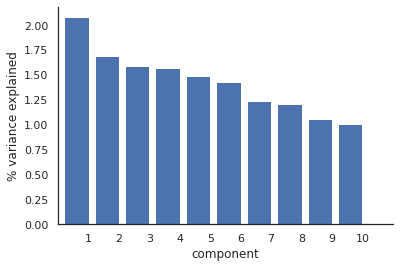

In [6]:
IDs = meta_data_samples.callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


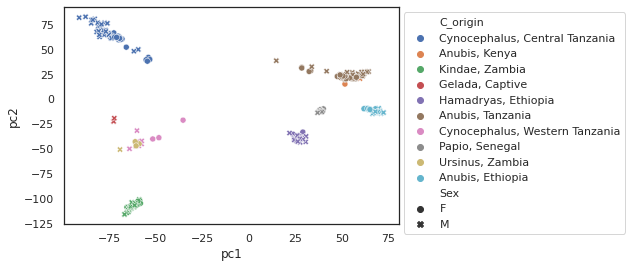

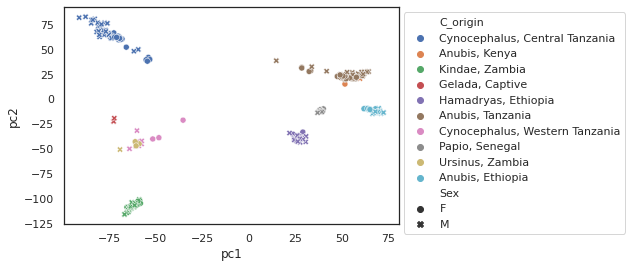

In [7]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin", style="Sex")
fig_males = scatter_sns.get_figure()
lgd = offset_legend(fig_males)
fig_males.savefig("../results/pca_x_with_males", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_males

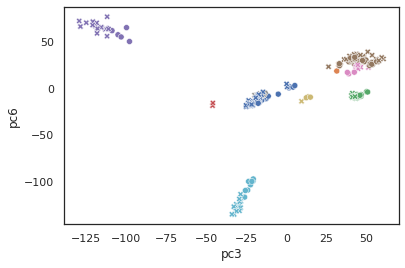

In [8]:
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc6", hue="C_origin", style="Sex")
scatter_sns.legend([],[], frameon=False)

With all individuals, the captive geladas dominate pc4, papio dominate pc5, so the most informative pcs beyond 1/2 are 3/6.

Loading the sites to keep, which I created in dp03

In [9]:
masked_sites = np.load("../data/kept_pos_x_female.npy")
gt_masked_sites = gt.take(masked_sites, axis=0)

Investigating 99 individuals
iteration 1 retaining 92538 removing 1450712 variants
iteration 2 retaining 9904 removing 82634 variants


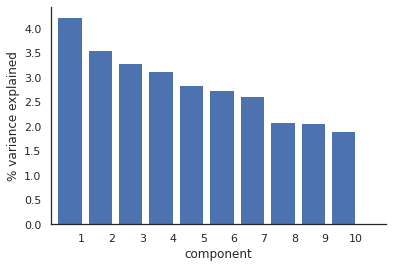

In [10]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.015)
                             & (meta_data_samples.Sex == "F")].callset_index.values
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

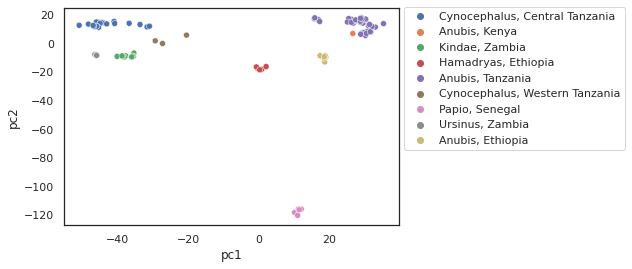

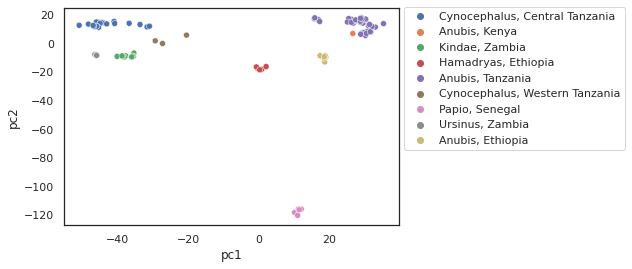

In [12]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="C_origin")
fig_females = scatter_sns.get_figure()
scatter_sns.legend(bbox_to_anchor=(1., 1.03, 0., 0))
fig_females.savefig("../results/pca_x_females", bbox_extra_artists=[lgd], bbox_inches='tight')
fig_females

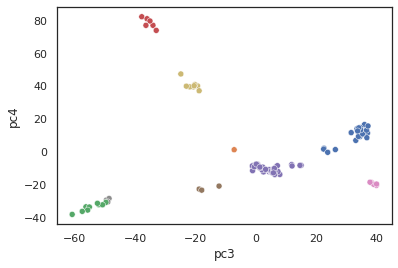

In [13]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc3", y="pc4", hue="C_origin")
scatter_sns.legend([],[], frameon=False)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


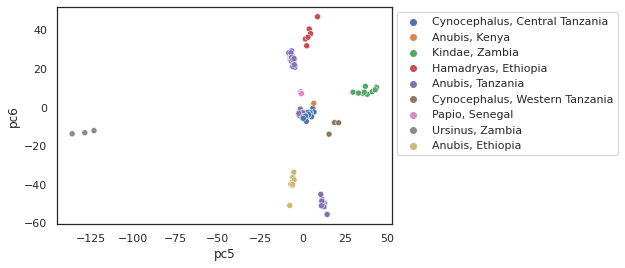

In [14]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc5", y="pc6", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

Investigating 90 individuals
iteration 1 retaining 88776 removing 1408242 variants
iteration 2 retaining 13101 removing 75675 variants


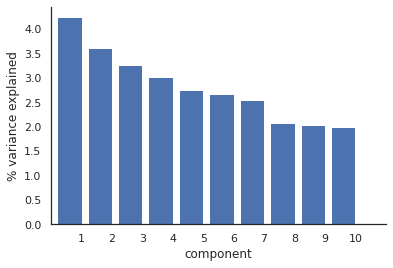

In [15]:
IDs = meta_data_samples.loc[(meta_data_samples.x_missing <= 0.01)
                             & (meta_data_samples.Sex == "F")].callset_index.values
pca_df = pruning_and_pca(gt, IDs, 3000000, 500, 2)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


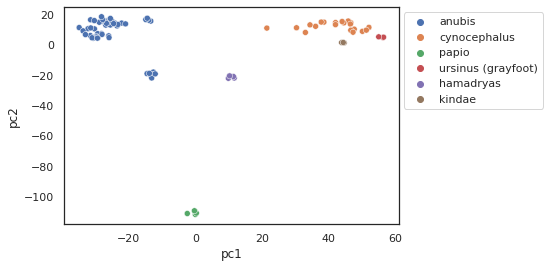

In [16]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc2", hue="Species")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

Taking 5, which are of speices Cynocephalus, Central Tanzania
Taking 1, which are of speices Anubis, Kenya
Taking 3, which are of speices Kindae, Zambia
Taking 0, which are of speices Gelada, Captive
Taking 5, which are of speices Hamadryas, Ethiopia
Taking 5, which are of speices Anubis, Tanzania
Taking 3, which are of speices Cynocephalus, Western Tanzania
Taking 5, which are of speices Papio, Senegal
Taking 3, which are of speices Ursinus, Zambia
Taking 5, which are of speices Anubis, Ethiopia
Investigating 35 individuals
iteration 1 retaining 38663 removing 1125817 variants
iteration 2 retaining 1900 removing 36763 variants


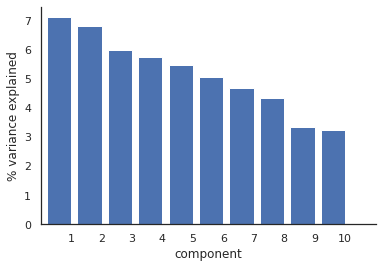

In [20]:
#Only taking 5 individuals per cluster.
females = meta_data_samples.loc[(meta_data_samples.Sex == "F")  & (meta_data_samples.x_missing <= 0.01)]
IDs = []

for cluster in meta_data_samples.C_origin.unique():
    cluster_IDs = females.loc[females.C_origin == cluster]
    n = min(5, len(cluster_IDs))
    print("Taking {}, which are of speices {}".format(n, cluster))
    IDs.extend(np.random.choice(cluster_IDs.callset_index.values, n, replace=False))
pca_df = pruning_and_pca(gt_masked_sites, IDs, 3000000, 500, 2)

In [21]:
pca_df.iloc[:, [0,1,15]]

,pc1,pc2,Species
0,-17.923992,-1.685731,cynocephalus
1,-17.558493,-1.925032,cynocephalus
2,-17.873594,-2.588798,cynocephalus
3,-19.844994,-1.676674,cynocephalus
4,-18.066309,-3.637653,cynocephalus
5,17.644302,18.601812,anubis
6,-25.208836,-4.754944,kindae
7,-26.540688,-4.679705,kindae
8,-28.240713,-5.202678,kindae
9,8.487789,12.769118,hamadryas


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


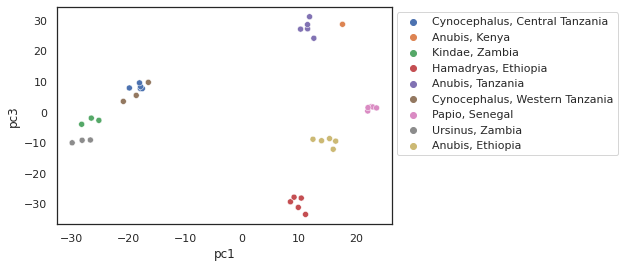

In [24]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc1", y="pc3", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)

In [ ]:
plt.close()
scatter_sns = sns.scatterplot(data = pca_df, x="pc4", y="pc3", hue="C_origin")
fig_females = scatter_sns.get_figure()
lgd = offset_legend(fig_females)